In [2]:
import os
from os import walk
from os import listdir
from os.path import isfile, join
import cv2
from matplotlib.pyplot import imshow
import numpy as np
import cv2
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

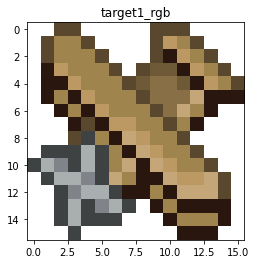

target1_rgb.shape:(16, 16, 3)
target2_rgb.shape:(16, 16, 3)
target2_1_rgb.shape:(16, 16, 3)
source_rgb.shape:(16, 16, 3)


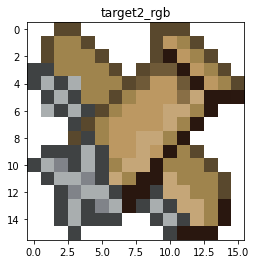

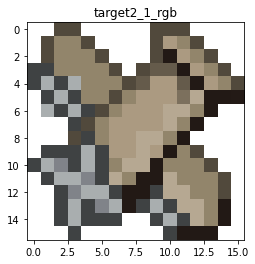

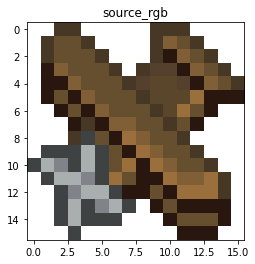

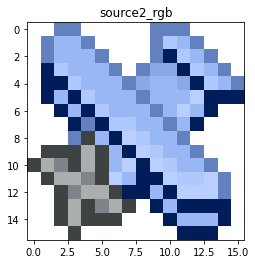

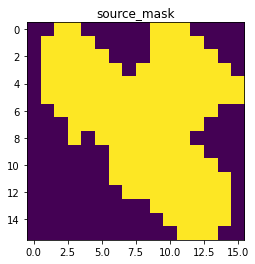

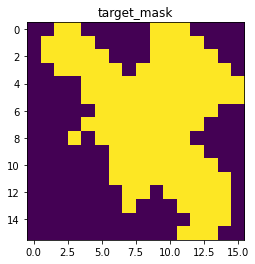

In [3]:
# im1 = cv2.imread("boats\\holly_boat.png")
target1 = cv2.imread("item\\oak_plane.png", cv2.IMREAD_UNCHANGED)
if np.any(target1[..., -1] < 100):
    target1[target1[..., -1] < 100] = [255, 255, 255, 255]
target1_rgb = cv2.cvtColor(target1, cv2.COLOR_BGRA2RGB)
target1_lab = cv2.cvtColor(target1_rgb, cv2.COLOR_BGR2LAB)
target1_hls = cv2.cvtColor(target1_rgb, cv2.COLOR_BGR2HLS)
plt.imshow(target1_rgb)
plt.title("target1_rgb")
plt.show()
print(f"target1_rgb.shape:{target1_rgb.shape}")

target2 = cv2.imread("mega\\oak_mega_plane.png", cv2.IMREAD_UNCHANGED)
if np.any(target2[..., -1] < 100):
    target2[target2[..., -1] < 100] = [255, 255, 255, 255]
target2_rgb = cv2.cvtColor(target2, cv2.COLOR_BGRA2RGB)
target2_lab = cv2.cvtColor(target2_rgb, cv2.COLOR_BGR2LAB)
target2_hls = cv2.cvtColor(target2_rgb, cv2.COLOR_BGR2HLS)
plt.imshow(target2_rgb)
plt.title("target2_rgb")
plt.show()
print(f"target2_rgb.shape:{target2_rgb.shape}")

target2_1 = cv2.imread("mega\\bop_dead_mega_plane.png", cv2.IMREAD_UNCHANGED)
if np.any(target2_1[..., -1] < 100):
    target2_1[target2_1[..., -1] < 100] = [255, 255, 255, 255]
target2_1_rgb = cv2.cvtColor(target2_1, cv2.COLOR_BGRA2RGB)
target2_1_lab = cv2.cvtColor(target2_1_rgb, cv2.COLOR_BGR2LAB)
target2_1_hls = cv2.cvtColor(target2_1_rgb, cv2.COLOR_BGR2HLS)
plt.imshow(target2_1_rgb)
plt.title("target2_1_rgb")
plt.show()
print(f"target2_1_rgb.shape:{target2_1_rgb.shape}")

source = cv2.imread("item\\spruce_plane.png", cv2.IMREAD_UNCHANGED)
if np.any(source[..., -1] < 100):
    source[source[..., -1] < 100] = [255, 255, 255, 255]
source_rgb = cv2.cvtColor(source, cv2.COLOR_BGRA2RGB)
source_lab = cv2.cvtColor(source_rgb, cv2.COLOR_BGR2LAB)
source_hls = cv2.cvtColor(source_rgb, cv2.COLOR_BGR2HLS)
plt.imshow(source_rgb)
plt.title("source_rgb")
plt.show()
print(f"source_rgb.shape:{source_rgb.shape}")

source2 = cv2.imread("item\\bop_magic_plane.png", cv2.IMREAD_UNCHANGED)
if np.any(source2[..., -1] < 100):
    source2[source2[..., -1] < 100] = [255, 255, 255, 255]
source2_rgb = cv2.cvtColor(source2, cv2.COLOR_BGRA2RGB)
source2_lab = cv2.cvtColor(source2_rgb, cv2.COLOR_BGR2LAB)
source2_hls = cv2.cvtColor(source2_rgb, cv2.COLOR_BGR2HLS)

plt.imshow(source2_rgb)
plt.title("source2_rgb")
plt.show()

source_mask = ~np.all(source == source2,axis=2)
plt.imshow(source_mask.astype(int))
plt.title("source_mask")
plt.show()

target_mask = ~np.all(target2_1 == target2,axis=2)
plt.imshow(target_mask.astype(int))
plt.title("target_mask")
plt.show()

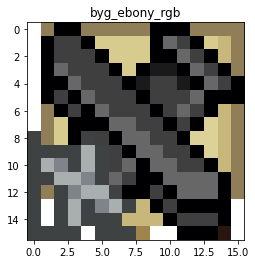

(142, 3)
(142, 3)
(127, 3)
(142, 10)
(127, 10)
(16, 16)
(127,)


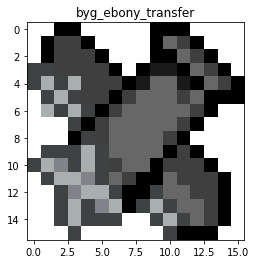

In [15]:
def color_transfer(source, target1, target2, mask, target_mask):
    X =target1 [mask]
    print(X.shape)
    Y = source[mask]
    print(Y.shape)
    X2 = target2[target_mask]
    print(X2.shape)
    Y_predicts = np.zeros_like(target2[target_mask])
    # for i in range(3):
    #     poly = PolynomialFeatures(1)
    #     X_ = poly.fit_transform(X[:,i,np.newaxis])
    #     print(X_.shape)
    #     clf = linear_model.LinearRegression()
    #     clf.fit(X_, Y[:,i,np.newaxis])
    #     X2_ = poly.fit_transform(X2[:,i,np.newaxis])
    #     print(X2_.shape)
    #     Y_predicts[:,i] = (clf.predict(X2_))[:,0]
    # for i in range(3):
    poly = PolynomialFeatures(2)
    X_ = poly.fit_transform(X)
    print(X_.shape)
    clf = linear_model.LinearRegression()
    clf.fit(X_, Y)
    X2_ = poly.fit_transform(X2)
    print(X2_.shape)
    Y_predicts = (clf.predict(X2_))
    # Y_predict = np.array(Y_predicts)
    result = target2.copy()
    print(target_mask.shape)
    result[target_mask] = Y_predicts
    # result[:,:,1] = target2[:,:,1]
    print(result[target_mask][:,0].shape)
    return result

# im3_lab = color_transfer(source_hls,target1_hls,target2_hls,source_mask,target_mask)
# im3_rgb = cv2.cvtColor(im3_lab, cv2.COLOR_HLS2BGR)
# im3_lab = color_transfer(source_lab,target1_lab,target2_lab,source_mask,target_mask)
# im3_rgb = cv2.cvtColor(im3_lab, cv2.COLOR_LAB2BGR)
# im3_rgb = color_transfer(source_rgb,target1_rgb,target2_rgb,source_mask,target_mask)
#
#
# plt.imshow(im3_rgb)
# plt.title("transfer")
# plt.show()

def im_color(mat):
    s = cv2.imread(f"item\\{mat}_plane.png", cv2.IMREAD_UNCHANGED)
    if np.any(s[..., -1] < 100):
        source2[s[..., -1] < 100] = [255, 255, 255, 255]
    s_rgb = cv2.cvtColor(s, cv2.COLOR_BGRA2RGB)
    s_lab = cv2.cvtColor(s_rgb, cv2.COLOR_BGR2LAB)
    s_hls = cv2.cvtColor(s_rgb, cv2.COLOR_BGR2HLS)
    plt.imshow(s_rgb)
    plt.title(f"{mat}_rgb")
    plt.show()
    im3_rgb = color_transfer(s_rgb,target1_rgb,target2_rgb,source_mask,target_mask)
    plt.imshow(im3_rgb)
    plt.title(f"{mat}_transfer")
    plt.show()

im_color("byg_ebony")

In [ ]:
mod_dict = {"bop": "biomesoplenty",
            "": "minecraft",
            "byg": "byg",
            "ft": "fruittrees"}

for f1 in os.listdir("../src/main/resources/assets/simpleplanes/textures/item"):
    mat = f1
    # print(f""""simpleplanes:{mat}",""")
    # continue

    if "_large_pl" not in mat:
        continue
    # if "byg" in mat:
    #     continue
    mat = mat.replace("_large_plane.png", "")
    # if "dark" not in mat:
    #     continue
    #     mat = mat.split("_")[1]
    Mat = mat.title()
    Mat = Mat.split('_')
    if Mat[0] in ["Bop", "Ft", "Byg"]:
        mod_short = Mat[0].lower()
        mod = mod_dict[mod_short]
        mod_short += "_"
        Mat = Mat[1:]
    else:
        mod = "minecraft"
        mod_short = ""
    # print(f""""mat:{mat}",mod:{mod}""")

    # Mat = " ".join(Mat)
    Mat = "_".join(Mat)
    mat = Mat.lower()
    print(f"(\"{mat}\"),")
    im_color(mat.lower())

